---
# pRF deviation
Marcus found a mistake in my pRF-fitting on which the line-scanning acquisition was based. I wrongly used the screen *width* as `screen size`, rather than the screen *height*. Instead of using 39.3cm as size, I used 70cm, which could have skewed the pRFs towards the fovea. Here, I try to elucidate the effect this error had on the line-pRF experiment

In [114]:
%matplotlib inline
from linescanning import utils,prf,plotting
import numpy as np
import matplotlib.pyplot as plt
from prfpy import stimulus, model
import os
opj = os.path.join

In [2]:
# set some paths
deriv_dir = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives"
ses1_data = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf"

In [145]:
subj_list = ["008"]
for sub in subj_list:

    # first, get the pRF with the wrong screen size
    search_for = ['desc-avg_bold_hemi-LR']
    bold = utils.get_file_from_substring(search_for, opj(ses1_data, f"sub-{sub}", "ses-1"))

    # fetch the best vertex
    obj_orig = prf.CollectSubject(f'sub-{sub}', derivatives=deriv_dir, settings='recent', hemi="lh", model='norm')
    pred = obj_orig.target_prediction_prf(make_figure=False)

    # actual BOLD data
    tc = obj_orig.func_data_l[:,obj_orig.target_vertex]

    # fit with correct screensize
    obj_correct = prf.pRFmodelFitting(tc[np.newaxis,...], 
                                      design_matrix=obj_orig.design_matrix, 
                                      TR=obj_orig.modelling.TR, 
                                      model=obj_orig.model, 
                                      stage=obj_orig.modelling.stage, 
                                      verbose=False)
    
    obj_correct.fit()

Using settings file: /data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-008/ses-1/20220603_model-norm_desc-settings.yml
Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7fb04fd16250>
Inserting parameters in 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7fb04fd79df0>


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.1s finished


Honestly, I should have known already that something was up. If I plot the pRF with the `wrong` screen size, the pRF-coordinates do not align with the visual field axis of the plot. 

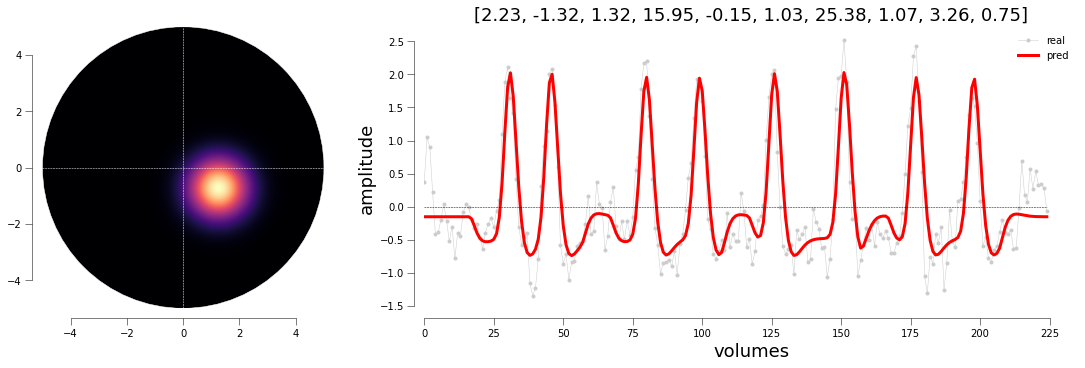

In [96]:
obj_orig.modelling.prf_stim.screen_size_cm = 70
obj_orig.target_prediction_prf(axis_off=False)

If I overwrite the screen size, the pRF ends up where it should be:

39.3


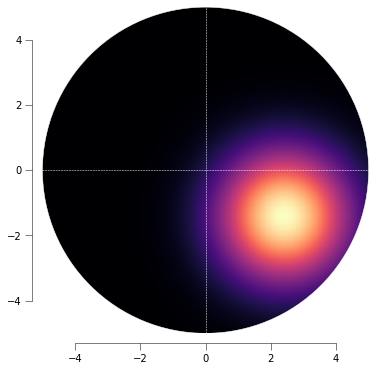

In [104]:
# We need to get the pRF location of the original estimates given the correct screen size
prf_corr = prf.make_prf(obj_correct.prf_stim, mu_x=obj_orig.target_params[0], mu_y=obj_orig.target_params[1], size=obj_orig.target_params[2])
plotting.LazyPRF(prf_corr, vf_extent=[-5,5], axis_off=False,figsize=(6,6))

Get the correct pRF location

39.3


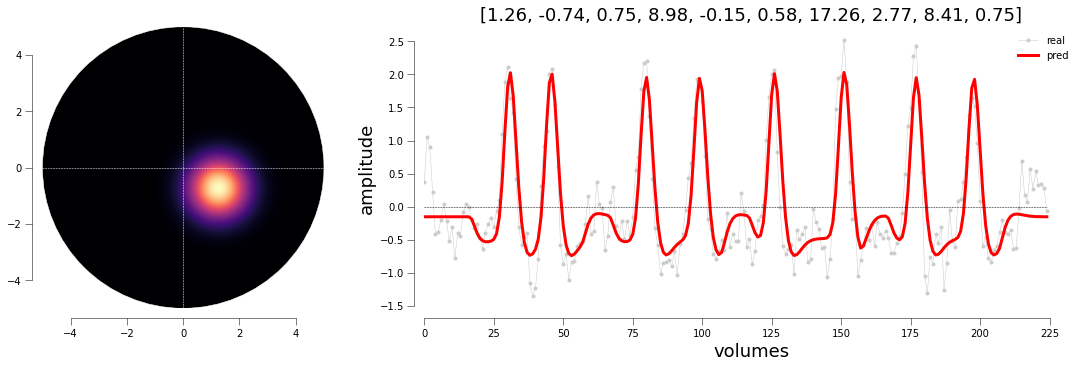

In [111]:
correct_prf = obj_correct.plot_vox(axis_off=False, title='pars', model='norm')

Now, we already performed a pRF experiment on a location that's based on the wrong screen size. Below we can get the prediction of the correct pRF given that same prf design

In [113]:
# get design
log_dir = f"/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/sourcedata/sub-{sub}/ses-2/sub-{sub}_ses-2_task-pRF_run-imgs"
design = prf.create_line_prf_matrix(log_dir, 
                                    stim_duration=0.25, 
                                    nr_trs=3200,
                                    stim_at_half_TR=True,
                                    n_pix=100,
                                    TR=0.105)

In [121]:
obj_correct.norm_iter.shape

(1, 10)

In [127]:
# set up HRF
hrf = model.HRF()
hrf.create_spm_hrf(hrf_params=[1,1,0], TR=0.105, force=True)

# set up stimulus
stim_ = stimulus.PRFStimulus2D(screen_size_cm=39.3, screen_distance_cm=225, design_matrix=design,TR=0.105)

# set up model
model_ = model.Norm_Iso2DGaussianModel(stimulus=stim_, hrf=hrf)

# get predictions
pred_wrong = np.squeeze(model_.return_prediction(*obj_orig.normalization_params).T)
pred_correct = np.squeeze(model_.return_prediction(*np.squeeze(obj_correct.norm_iter, axis=0)).T)

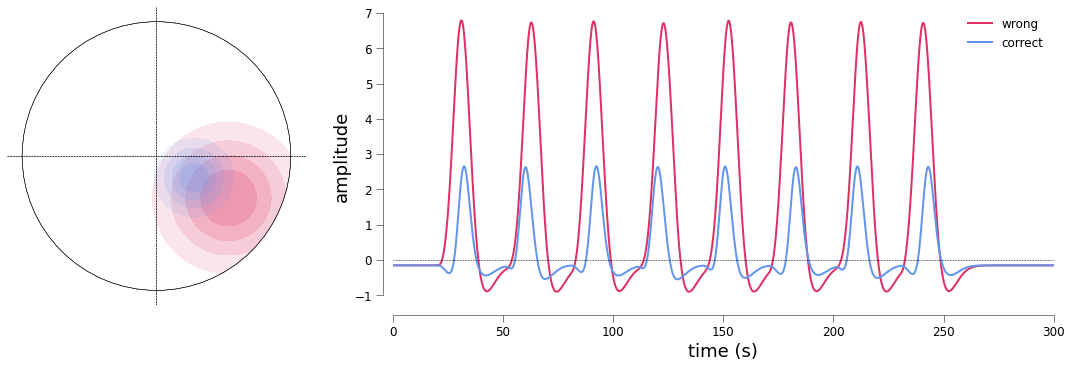

In [138]:
fig = plt.figure(constrained_layout=True, figsize=(15,5))
gs = fig.add_gridspec(1,2, width_ratios=[10,20])

# create different colormaps
colors = ["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])
cmap2 = utils.make_binary_cm(colors[1])
cmaps = [cmap1, cmap2]
x_axis = np.array(list(np.arange(0,design.shape[-1])*0.105))

# initiate and plot figure
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
for ix, obj in enumerate([prf_corr, correct_prf[1]]):
    plotting.LazyPRF(obj, 
                     vf_extent=obj_orig.settings['vf_extent'], 
                     ax=ax1, 
                     cmap=cmaps[ix], 
                     cross_color='k', 
                     alpha=0.5,
                     shrink_factor=0.9)

plotting.LazyPlot([pred_wrong,pred_correct],
                  xx=x_axis,
                  color=colors, 
                  labels=['wrong', 'correct'], 
                  add_hline='default',
                  x_label="time (s)",
                  y_label="amplitude",
                  axs=ax2,
                  line_width=[2,2],
                  x_lim=[0,300],
                  label_size=12,
                  font_size=18)

In [141]:
# fit with correct screensize
obj_correct = prf.pRFmodelFitting(tc[np.newaxis,...], 
                                  design_matrix=obj_orig.design_matrix, 
                                  TR=obj_orig.modelling.TR, 
                                  model=obj_orig.model, 
                                  stage=obj_orig.modelling.stage, 
                                  verbose=False)
obj_correct.fit()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.2s finished


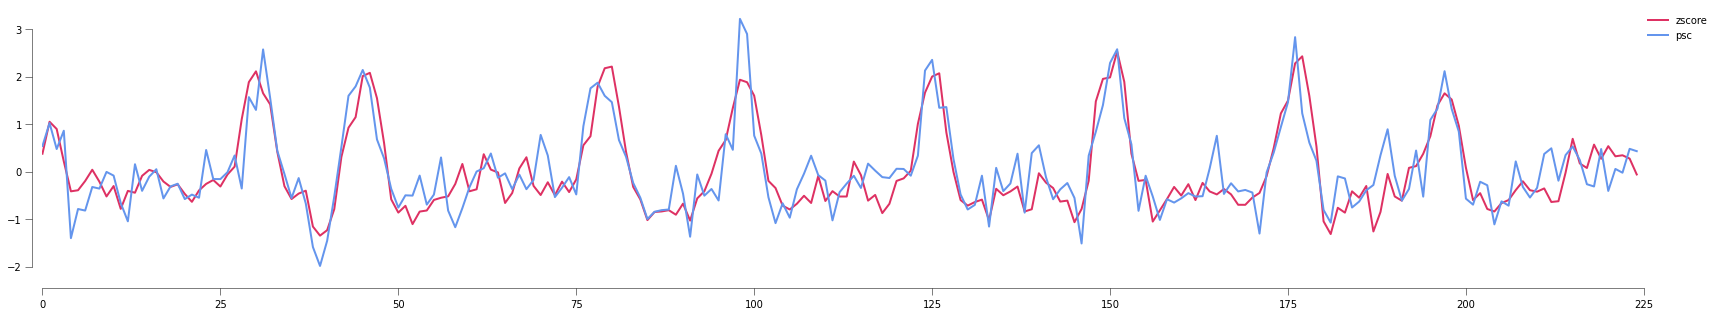

In [150]:
tc1 = tc

psc_file = "/data1/projects/MicroFunc/Jurjen/projects/WB-pRF/derivatives/prf/sub-008/ses-1/sub-008_ses-1_task-2R_hemi-L_desc-avg_bold.npy"
tc2 = np.load(psc_file)[:,10009]
plotting.LazyPlot([tc1,tc2], color=colors, line_width=2, labels=['zscore', 'psc'])

In [156]:
raw_lh = np.load('/data1/projects/MicroFunc/Jurjen/projects/WB-pRF/derivatives/pybest/sub-008/ses-1/denoising/sub-008_ses-1_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold_raw.npy')
raw_rh = np.load('/data1/projects/MicroFunc/Jurjen/projects/WB-pRF/derivatives/pybest/sub-008/ses-1/denoising/sub-008_ses-1_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold_raw.npy')


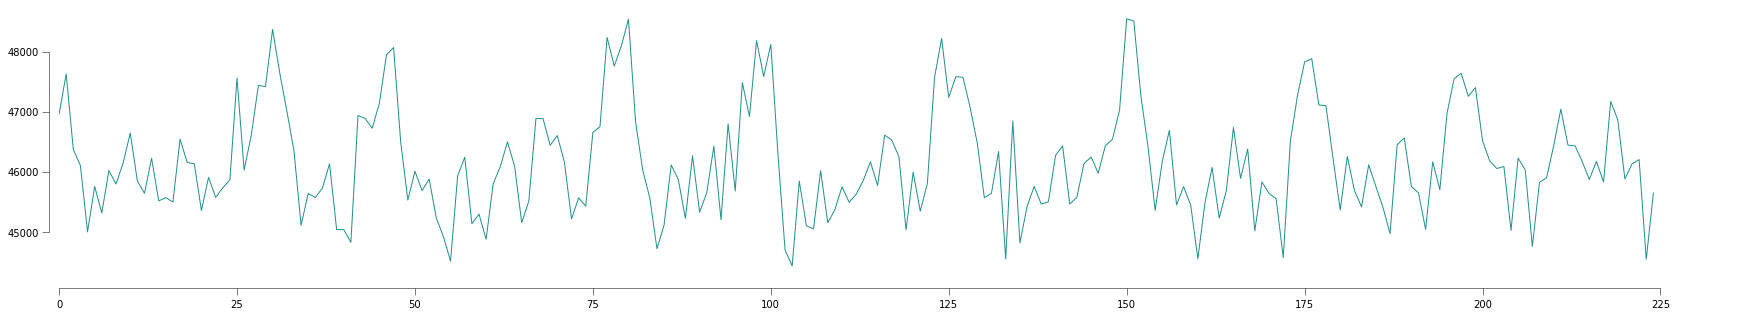

In [164]:

m_prf_tc_data = np.hstack((raw_lh, raw_rh))
plotting.LazyPlot(m_prf_tc_data[:,10009])

In [ ]:

m_prf_tc_data *= (100/np.mean(m_prf_tc_data, axis=0))

timepoints_no_stim = prf.baseline_from_dm(obj_orig.design_matrix)
print(timepoints_no_stim)
median_baseline = np.median(m_prf_tc_data[timepoints_no_stim,:], axis=0)
print(median_baseline)

m_prf_tc_data -= median_baseline

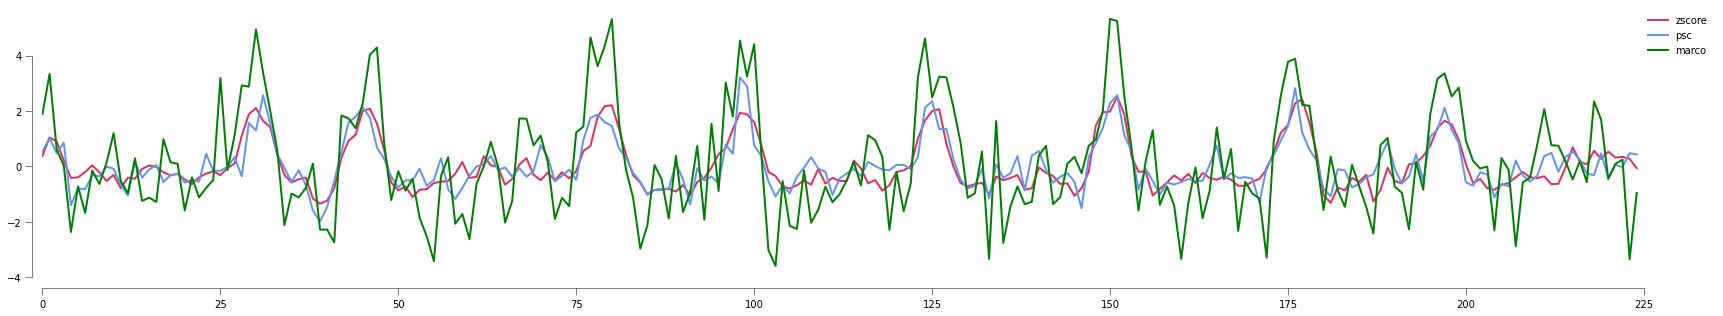

In [161]:
tc3 = m_prf_tc_data[:,10009]
plotting.LazyPlot([tc1,tc2,tc3], color=colors+['g'], line_width=2, labels=['zscore', 'psc', 'marco'])

In [163]:
np.median(tc3[timepoints_no_stim])

0.0

In [1]:
from scipy.stats import zscore
zscored = zscore(m_prf_tc_data, axis=0)
plotting.LazyPlot(zscored[:,10009])

NameError: name 'm_prf_tc_data' is not defined